# Simulação com Scikit-Learn

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.gridspec as gridspec
import csv
from sklearn import svm
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.datasets import make_classification
import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(123455)

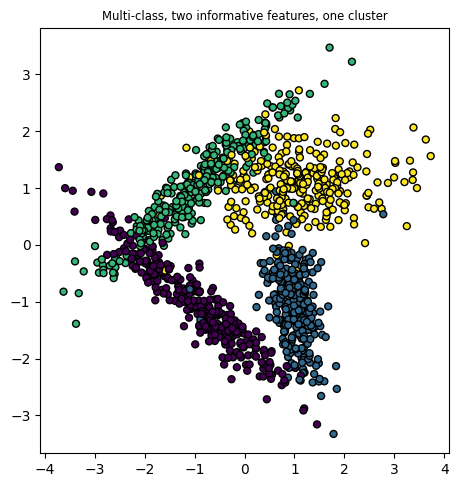

In [3]:
plt.figure(figsize=(10, 5))
plt.subplots_adjust(bottom=.05, top=.9, left=.05, right=.95)
plt.subplot(121)
plt.title("Multi-class, two informative features, one cluster", fontsize='small')
X1, Y1 = make_classification(n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1, n_classes=4, n_samples=1200)
plt.scatter(X1[:, 0], X1[:, 1], marker='o', c=Y1, s=25, edgecolor='k') # type: ignore
plt.show()

In [4]:
f= open('Data/conjuntoZ.txt',"w")

indices = np.unique(Y1)

for i in indices:
    pos = np.where(Y1 == i)[0]
    for p in pos:
        st = str(i)
        for j in range(0,X1.shape[1]):
            st += ','+ str(X1[p,j])
        st += '\n'
        f.write(st)
f.close()

In [5]:
def read_class_data(path):
    with open(path, newline='') as f:
        reader = csv.reader(f,delimiter=',')
        for row in reader:
            try:
                data = np.vstack((data, np.asarray(row).astype(float))) # type: ignore
            except:
                data = np.asarray(row).astype(float)
    f.close()
    y = data[:,0] # type: ignore
    x = data[:, 1:] # type: ignore
    return y,x

In [6]:
path_Z = 'Data/conjuntoZ.txt'
y,x = read_class_data(path_Z)

In [7]:
#Gerar conjunto de treino e avaliação a partir de uma única fonte
N = y.shape[0]
percentAvalia = 0.833

#A ordenação dos valores aleatórios segundo seu índice/argumento
#O resultado é uma nova ordem aleatória (mais conveniente para este caso)
posAleatorias = np.argsort(np.random.uniform(0,1, y.shape[0] ))

#Subconjunto de avaliação
yI = y[posAleatorias[0: np.int64(np.ceil(N*percentAvalia))]]
xI = x[posAleatorias[0: np.int64(np.ceil(N*percentAvalia))], :]

#Subconjunto de treino
yD = y[posAleatorias[np.int64(np.floor(N*percentAvalia)):-1]]
xD = x[posAleatorias[np.int64(np.floor(N*percentAvalia)):-1], :]


### Normalização dos dados...

In [8]:
escalonador = preprocessing.MinMaxScaler()

escalonador.fit(xD)
xD = escalonador.transform(xD)
xI = escalonador.transform(xI)

In [9]:
xI.max()

1.1357946154050684

### Classificação dos dados
---
* "g = MLPClassifier" é a instanciação do classificador MLP
* "g.fit" e "g.predict" realiza o treinamento e aplicação do método na predição de classes
---
* Definimos a arquiteturas (segundo hidden_layer_sizes):
* Os demais parâmetros podem ser consultados na documentação

In [10]:
arquitetura = (3,3,3)

g = MLPClassifier(solver='lbfgs', hidden_layer_sizes=arquitetura, max_iter=10000, tol=10**(-5),
    activation='tanh', learning_rate='constant', shuffle=True, random_state=1)

g.fit(xD,yD)

MLPClassifier(activation='tanh', hidden_layer_sizes=(3, 3, 3), max_iter=10000,
              random_state=1, solver='lbfgs', tol=1e-05)

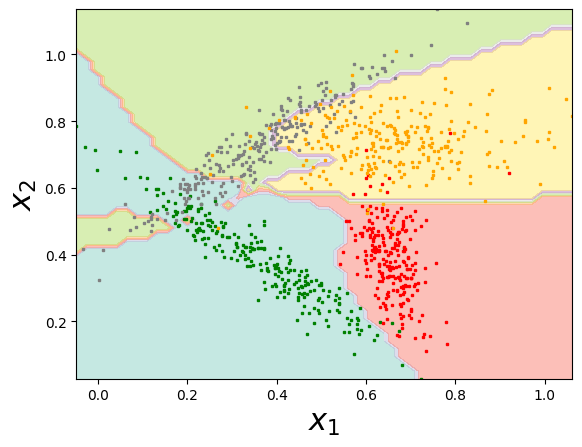

In [11]:
minX, maxX = (np.min(xI[:,0]), np.max(xI[:,0]))
minY, maxY = (np.min(xI[:,1]), np.max(xI[:,1]))

N = 50
X1 = np.linspace(minX, maxX,N)
X2 = np.linspace(minY, maxY,N)
X1, X2 = np.meshgrid(X1, X2)

cla = np.ndarray((N,N))
for i in range(0,N):
    for j in range(0,N):
        cla[i,j] = g.predict( [ [X1[i,j] , X2[i,j]] ] ) 

plt.contourf(X1, X2, cla, cmap=cm.Set3, alpha=0.5) # type: ignore
plt.plot( xI[np.where(yI == 0), 0], xI[np.where(yI == 0), 1], 's', color='green', markersize=2)
plt.plot( xI[np.where(yI == 1), 0], xI[np.where(yI == 1), 1], 's', color='red', markersize=2)
plt.plot( xI[np.where(yI == 2), 0], xI[np.where(yI == 2), 1], 's', color='grey', markersize=2)
plt.plot( xI[np.where(yI == 3), 0], xI[np.where(yI == 3), 1], 's', color='orange', markersize=2)
plt.xlabel('$x_1$', fontsize=22)
plt.ylabel('$x_2$', fontsize=22)
plt.show()

### Obtém centroide e variância via KMedias  

In [12]:
def init_kmeans(data,k,epsilon):
    m,dim = data.shape
    randPos = np.random.randint(0,m,k)
    cent = np.copy(data[randPos,:])
    centAnt = np.copy(data[randPos,:])
    count_cent = np.zeros((k))
    dist = np.zeros((k))
    it = 0

    while True:
        for i in range(0,m):
            for j in range(0,k):
                dist[j] = np.linalg.norm(cent[j,:] - data[i,:])
            posMin = np.where(dist == np.min(dist))
            cent[posMin,:] += data[i,:]
            count_cent[posMin] += 1
        
        deslocamento = 0
        for j in range(0,k):
            cent[j,:] /= count_cent[j]
            deslocamento += np.linalg.norm(cent[j,:] - centAnt[j,:])
            centAnt[j,:] = cent[j,:]

        it += 1
        if (deslocamento < epsilon) or (it > 1000): break

    campos = np.ones((k))
    count_campos = np.zeros((k)) 
    for i in range(0,m):
        for j in range(0,k):
            dist[j] = np.linalg.norm(cent[j,:] - data[i,:])
            posMin = np.where(dist == np.min(dist))
        
        count_campos[posMin] += 1 # type: ignore
        campos[posMin] += np.linalg.norm(cent[posMin,:] - data[i,:]) # type: ignore
    
    for j in range(0,k):
        campos[j] /= (count_campos[j] + 1)
    
    return cent, campos

### Função que transforma y das forma "índice" para "vetor"

In [13]:
def expected_output(y):
    uy = np.unique(y)
    nclass = np.size(uy)
    m = np.shape(y)[0]
    vecY = np.zeros((nclass,m))
    for i in range(0,m):
        pos = np.where(uy == y[i])
        vecY[pos,i] = 1
    return vecY

### Função que faz o mapeamento dos dados pelos neurônios escondidos da RBF

In [14]:
def map_rbf(x,mu,sig):
    m = x.shape[0]
    k = mu.shape[0]
    mappedX = np.ndarray((m,k))
    for i in range(0,m):
        for j in range(0,k):
            mappedX[i,j] = np.exp(-(np.linalg.norm(x[i,:] - mu[j,:])**2)/(2*(sig[j]**2)) )
    return mappedX

In [15]:
def train_rbf_net(x,y,k,epsilon):
    #Indicador de classe vetorial
    codeY = expected_output(y) 
    #Parâmetros dos neurônios da camada escondida (fase não supervisionado)
    cent, campo = init_kmeans(x,k,epsilon)
    #Mapeamento dos dados de acordo com os neurônios da camada escondida
    mapX = map_rbf(x,cent,campo)    
    #Ajuste dos pesos da camada de saída (fase supervisionado)
    A = np.dot( mapX.T , mapX)
    B = np.linalg.inv(A)
    C = np.dot(B , mapX.T)
    W = np.dot( C , codeY.T)
    return W, cent, campo

### Classificação com a rede RBF

In [16]:
def class_rbf_net(x,mu,sig,W):
    #Mapeia o elemento
    k = mu.shape[0]
    mx = np.ndarray((k))
    for j in range(0,k): mx[j] = np.exp(-(np.linalg.norm(x - mu[j,:])**2)/(2*(sig[j]**2)))
    #Aplica os pesos da última camada e decide em favor da maior resposta
    v = np.reshape(np.dot( np.reshape( mx , (1,W.shape[0])), W), (W.shape[1]))
    pos = np.where(v == np.max(v))
    
    return pos[0]+1

## Rede RBF

### Leitura dos dados
* Os dados considerados aqui foram obtidos do Observatório de Alagamento de Dartmounth (http://www.dartmouth.edu)

* Atributos são: Classe(indice-classe),Severidade,Longitude,Latitute,Duração (dias),Área afetada ($km^2$), Magnitude
* Maginitde = $log(Severidade \times Duracao \times Area\_afetada)$

* Classes: 
    * 1 - Chuva forte; (azul escuro)
    * 2 - Derretimento de gelo; (ciano)
    * 3 - Chuva torrencial; (verde)
    * 4 - Chuva de monção; (laranja)
    * 5 - Outros (ciclone, tornado, questões relacionadas a barragens e gelo) (magenta)

In [17]:
path = 'Data/FloodData.csv'
y,x_ = read_class_data(path)

### Normalizar os dados

In [18]:
x = np.copy(x_)
AtributosNormalizar = [2,3,4,5]

for i in AtributosNormalizar:
    mi = x[:,i].min()
    ma = x[:,i].max()
    a = 1/(ma-mi)
    b = -mi/(ma-mi)
    x[:,i] = a*x[:,i] + b

### Separação aleatória dos dados para treinamento e avaliação

In [19]:
N = y.shape[0]
percentAvalia = 0.33

#A ordenação dos valores aleatórios segundo seu índice/argumento
#O resultado é uma nova ordem aleatória (mais conveniente para este caso)
posAleatorias = np.argsort(np.random.uniform(0,1, y.shape[0]))

#Subconjunto de avaliação
yI = y[posAleatorias[0: np.int64(np.ceil(N*percentAvalia))]]
xI = x[posAleatorias[0: np.int64(np.ceil(N*percentAvalia))], :]

#Subconjunto de treino
yD = y[posAleatorias[np.int64(np.floor(N*percentAvalia)):-1]]
xD = x[posAleatorias[np.int64(np.floor(N*percentAvalia)):-1], :]

### Visualização dos dados de treino/classe

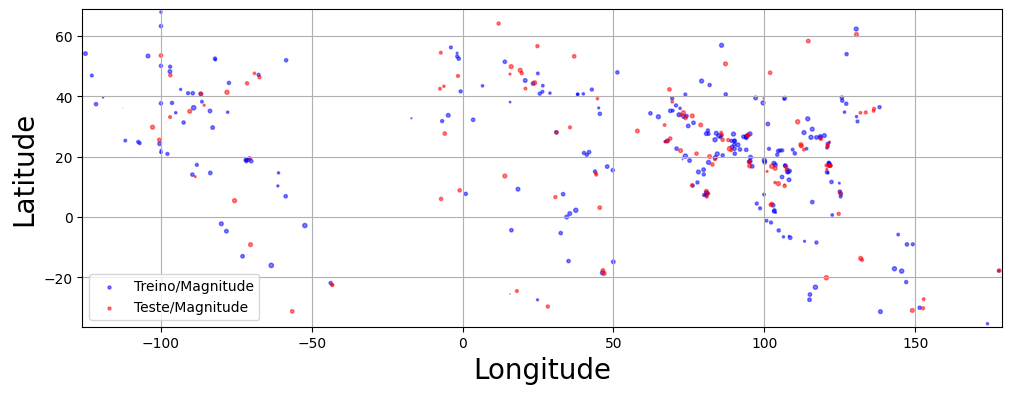

In [20]:
FS = (10,10)
fig = plt.figure(constrained_layout=True,figsize=FS)
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)

ax = fig.add_subplot(spec[0,0])
ax.scatter( xD[:,0], xD[:,1], s=xD[:,5]*10, c='blue', alpha=0.5, label='Treino/Magnitude')
ax.scatter( xI[:,0], xI[:,1], s=xI[:,5]*10, c='red', alpha=0.5, label='Teste/Magnitude')
ax.set_xlabel('Longitude',fontsize=20)
ax.set_ylabel('Latitude',fontsize=20)

ax.set(xlim=(np.min(xD[:,0])-1,np.max(xD[:,0])+1), ylim=(np.min(xD[:,1])-1,np.max(xD[:,1])+1))
ax.set_aspect('equal', 'box')

ax.legend(fontsize=10)
ax.grid(True)

### Visualizacão dos dados de treino/classe

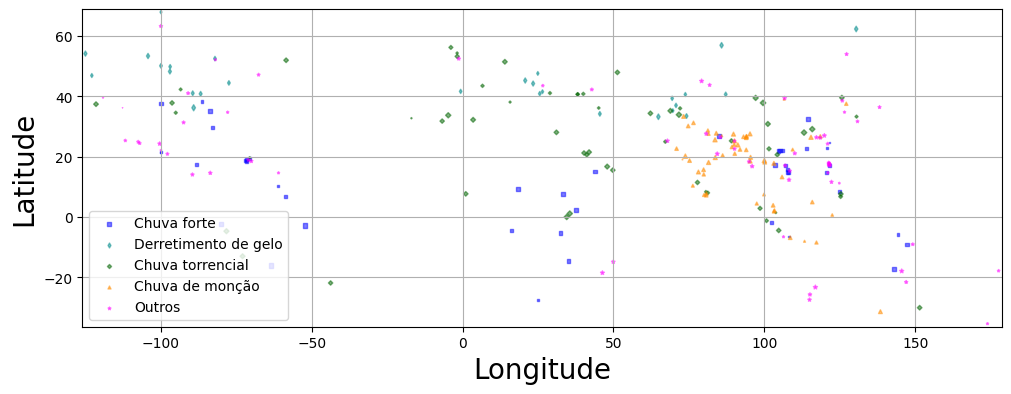

In [21]:
indClasse = [1,2,3,4,5]
cores = ['blue', 'darkcyan', 'darkgreen', 'darkorange', 'magenta']
simbolos = ['s', 'd', 'D', '^', '*']
nomes = ['Chuva forte', 'Derretimento de gelo', 'Chuva torrencial', 'Chuva de monção', 'Outros']

FS = (10,10)
fig = plt.figure(constrained_layout=True,figsize=FS)
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)

ax = fig.add_subplot(spec[0, 0])

for i,cor,simb,rotulo in zip(indClasse,cores,simbolos,nomes):
    pos = np.where(yD == i)[0]
    ax.scatter( xD[pos,0], xD[pos,1], s=xD[pos,5]*10, c=cor, marker=simb, alpha=0.5, label=rotulo) # type: ignore
    
ax.set_xlabel('Longitude',fontsize=20)
ax.set_ylabel('Latitude',fontsize=20)

ax.set(xlim=(np.min(xD[:,0])-1,np.max(xD[:,0])+1), ylim=(np.min(xD[:,1])-1, np.max(xD[:,1])+1))
ax.set_aspect('equal', 'box')

ax.legend()
ax.grid(True)

### Classificação dos dados
#### Parâmetros:
* $\texttt{k}$: número de neurônios na camada escondida
* $\texttt{epsilon}$: citério de convergência usado pelo método K-Médias (além de 1000 iterações)

In [22]:
k = 10
epsilon = 0.05
#0 - Longitude
#1 - Latitute, 
#2 - Severidade
#3 - Duração (dias)
#4 - Área afetada (𝑘𝑚2)
# 5 - Magnitude
atributos = [2,3,4,5]
xD_sub = xD[:,atributos]
xI_sub = xI[:,atributos]

W, cent, campo = train_rbf_net(xD_sub,yD,k,epsilon)

### Avaliação do desempenho
* Análise baseada na concordância (%) entre Predição $vs$ Esperado.

In [23]:
N = yI.shape[0]
yEst = np.zeros(N)

for i in range(0, N):
    padrao = xI_sub[i,:]
    yEst[i] = class_rbf_net(padrao, cent, campo, W)
    
concord_g = np.count_nonzero(yEst == yI) / yI.shape[0]
print('Acurácia: ', concord_g)

Acurácia:  0.31496062992125984


### Qual classe acerta/erra mais?

In [24]:
for i,rotulo in zip(indClasse,nomes):
    posClasse = np.where(yI == i)[0]
    acc = np.count_nonzero(yEst[posClasse] == yI[posClasse]) / yI[posClasse].shape[0]
    print(rotulo,': ',str(acc*100),'')

Chuva forte :  0.0 
Derretimento de gelo :  0.0 
Chuva torrencial :  60.0 
Chuva de monção :  38.70967741935484 
Outros :  38.46153846153847 


## SVM

In [25]:
path = 'Data/FloodData.csv'
y,x_ = read_class_data(path)

### Normalizar os dados

In [26]:
x = np.copy(x_)
AtributosNormalizar = [2,3,4,5]
for i in AtributosNormalizar:
    mi = x[:,i].min()
    ma = x[:,i].max()
    a = 1/(ma-mi)
    b = -mi/(ma-mi)
    x[:,i] = a*x[:,i] + b

In [27]:
N = y.shape[0]
percentAvalia = 0.33
posAleatorias = np.argsort(np.random.uniform(0,1, y.shape[0] ))

yI = y[ posAleatorias[0: np.int64(np.ceil(N*percentAvalia)) ] ]
xI = x[ posAleatorias[0: np.int64(np.ceil(N*percentAvalia)) ] , :]

yD = y[ posAleatorias[np.int64(np.floor(N*percentAvalia)):-1] ]
xD = x[ posAleatorias[np.int64(np.floor(N*percentAvalia)):-1] , :]

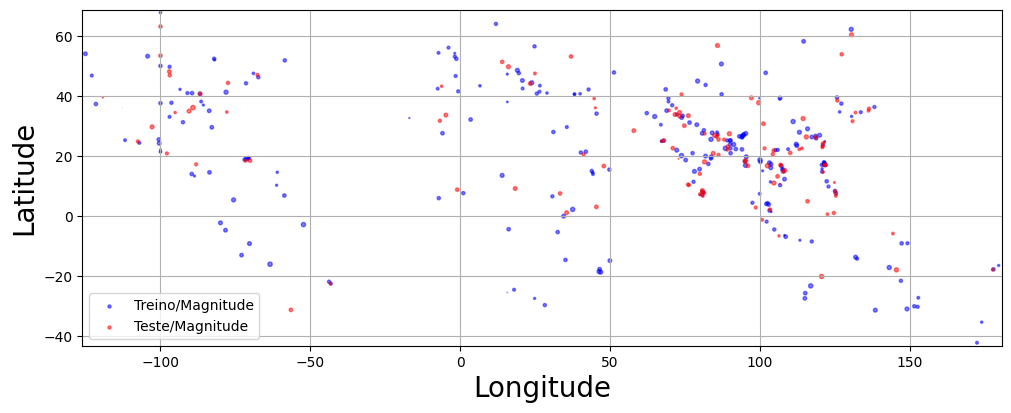

In [28]:
FS = (10,10)
fig = plt.figure(constrained_layout=True,figsize=FS)
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)

ax = fig.add_subplot(spec[0,0])
ax.scatter( xD[:,0], xD[:,1], s=xD[:,5]*10, c='blue', alpha=0.5, label='Treino/Magnitude')
ax.scatter( xI[:,0], xI[:,1], s=xI[:,5]*10, c='red', alpha=0.5, label='Teste/Magnitude')
ax.set_xlabel('Longitude',fontsize=20)
ax.set_ylabel('Latitude',fontsize=20)
ax.set(xlim=(np.min(xD[:,0])-1,np.max(xD[:,0])+1), ylim=(np.min(xD[:,1])-1,np.max(xD[:,1])+1))
ax.set_aspect('equal', 'box')
ax.legend(fontsize=10)
ax.grid(True)

### Visualizacão dos dados de treino/avaliação

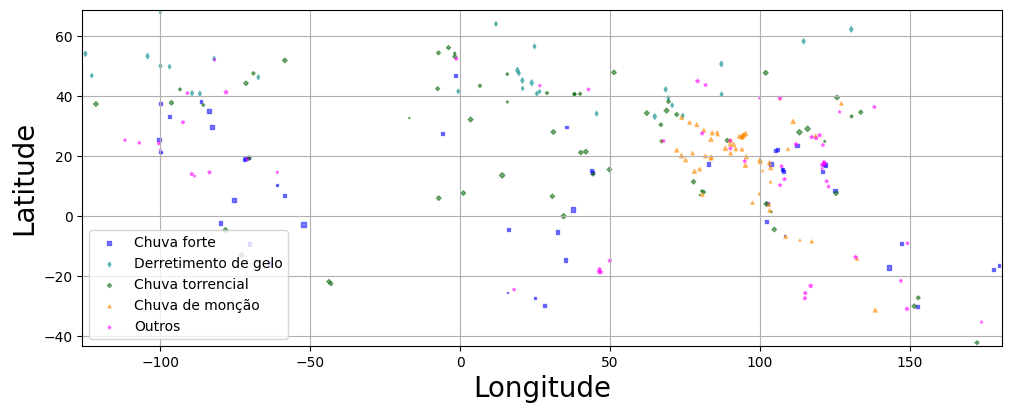

In [29]:
indClasse = [1,2,3,4,5]
cores = ['blue', 'darkcyan', 'darkgreen', 'darkorange', 'magenta']
simbolos = ['s', 'd', 'D', '^', '*']
nomes = ['Chuva forte', 'Derretimento de gelo', 'Chuva torrencial', 'Chuva de monção', 'Outros']

FS = (10,10)
fig = plt.figure(constrained_layout=True,figsize=FS)
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)

ax = fig.add_subplot(spec[0, 0])

for i,cor,simb,rotulo in zip(indClasse,cores,simbolos,nomes):
    pos = np.where(yD == i)[0]
    ax.scatter( xD[pos,0], xD[pos,1], s=xD[pos,5]*10, c=cor, marker=simb, alpha=0.5, label=rotulo) # type: ignore
    
ax.set_xlabel('Longitude',fontsize=20)
ax.set_ylabel('Latitude',fontsize=20)
ax.set(xlim=(np.min(xD[:,0])-1,np.max(xD[:,0])+1), ylim=(np.min(xD[:,1])-1,np.max(xD[:,1])+1))
ax.set_aspect('equal', 'box')
ax.legend()
ax.grid(True)

### Classificação dos dados
#### Diferentes configurações com funções kernel e parâmetros associados
* kernel = {polinomial, rbf, sigmoide}(6) -- 1 camada escondida com 6 neurônios $\rightarrow g_1$
* parametros... q = 5, gamma = {0.1,0.5}, alpha = 0
* Estratégia OVR e C=100

Outros parâmetros mantidos constantes

In [30]:
#Configurações consideradas
#g1 = svm.SVC(C=100, kernel='linear', decision_function_shape='ovr')
g1 = svm.SVC(C=100, kernel='poly', degree=5, coef0=0, gamma=1.0, decision_function_shape='ovr')
g2 = svm.SVC(C=100, kernel='rbf', gamma=1.5, decision_function_shape='ovr')
g3 = svm.SVC(C=100, kernel='sigmoid', coef0=0, gamma=0.1, decision_function_shape='ovr')

#0 - Severidade
#1 - Longitude
#2 - Latitute,
#3 - Duração (dias)
#4 - Área afetada (𝑘𝑚2)
#5 - Magnitude
atributos = [2,3,4,5]
xD_sub = xD[:,atributos]
xI_sub = xI[:,atributos]

#Treinamento dos classificadores 
g1.fit(xD_sub,yD)
g2.fit(xD_sub,yD)
g3.fit(xD_sub,yD)

SVC(C=100, coef0=0, gamma=0.1, kernel='sigmoid')

### Avaliação do desempenho
* Análise baseada na concordância (%) entre Predição $vs$ Esperado.

In [31]:
#Predição efetuada por cada uma das redes
yEst_g1 = g1.predict(xI_sub)
yEst_g2 = g2.predict(xI_sub)
yEst_g3 = g3.predict(xI_sub)

#Concordâncias...
concord_g1 = np.count_nonzero(yEst_g1 == yI) / yI.shape[0]
concord_g2 = np.count_nonzero(yEst_g2 == yI) / yI.shape[0]
concord_g3 = np.count_nonzero(yEst_g3 == yI) / yI.shape[0]

print('SVM 1: ', concord_g1)
print('SVM 2: ', concord_g2)
print('SVM 3: ', concord_g3)

SVM 1:  0.2440944881889764
SVM 2:  0.3543307086614173
SVM 3:  0.2992125984251969


### Qual classe acerta/erra mais?

In [32]:
for i in range(0,5):
    posClasse = np.where(yI == (i+1))
    acc = np.count_nonzero(yEst_g3[posClasse] == yI[posClasse]) / yI[posClasse].shape[0]
    print(nomes[i],': ',str(acc*100),'')

Chuva forte :  0.0 
Derretimento de gelo :  0.0 
Chuva torrencial :  65.38461538461539 
Chuva de monção :  31.25 
Outros :  30.555555555555557 


## CART

In [33]:
path = 'Data/FloodData.csv'
y,x_ = read_class_data(path)
x = np.copy(x_)
AtributosNormalizar = [2,3,4,5]

for i in AtributosNormalizar:
    mi = x[:,i].min()
    ma = x[:,i].max()
    a = 1/(ma-mi)
    b = -mi/(ma-mi)
    x[:,i] = a*x[:,i] + b

N = y.shape[0]
percentAvalia = 0.33
posAleatorias = np.argsort(np.random.uniform(0,1, y.shape[0] ))

#Subconjunto de avaliação
yI = y[ posAleatorias[0: np.int64(np.ceil(N*percentAvalia)) ] ]
xI = x[ posAleatorias[0: np.int64(np.ceil(N*percentAvalia)) ] , :]

#Subconjunto de treino
yD = y[ posAleatorias[np.int64(np.floor(N*percentAvalia)):-1] ]
xD = x[ posAleatorias[np.int64(np.floor(N*percentAvalia)):-1] , :]

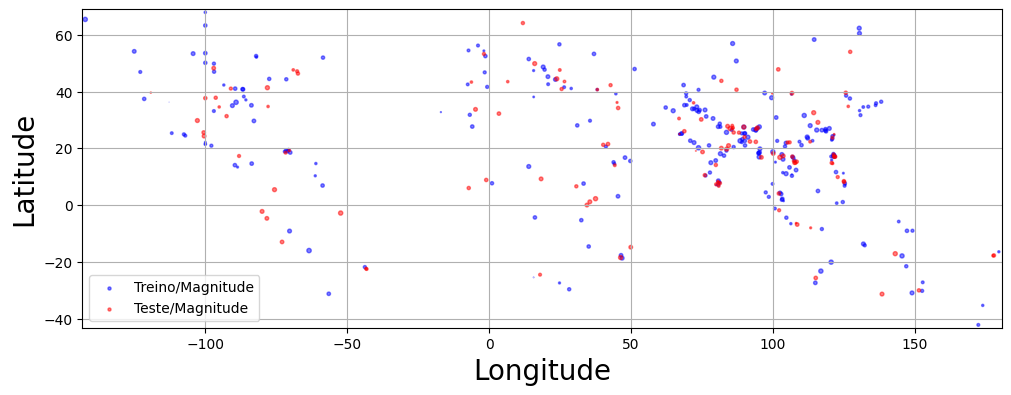

In [34]:
FS = (10,10)
fig = plt.figure(constrained_layout=True,figsize=FS)
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)

ax = fig.add_subplot(spec[0,0])
ax.scatter( xD[:,0], xD[:,1], s=xD[:,5]*10, c='blue', alpha=0.5, label='Treino/Magnitude')
ax.scatter( xI[:,0], xI[:,1], s=xI[:,5]*10, c='red', alpha=0.5, label='Teste/Magnitude')
ax.set_xlabel('Longitude',fontsize=20)
ax.set_ylabel('Latitude',fontsize=20)
ax.set(xlim=(np.min(xD[:,0])-1,np.max(xD[:,0])+1), ylim=(np.min(xD[:,1])-1,np.max(xD[:,1])+1))
ax.set_aspect('equal', 'box')
ax.legend(fontsize=10)
ax.grid(True)

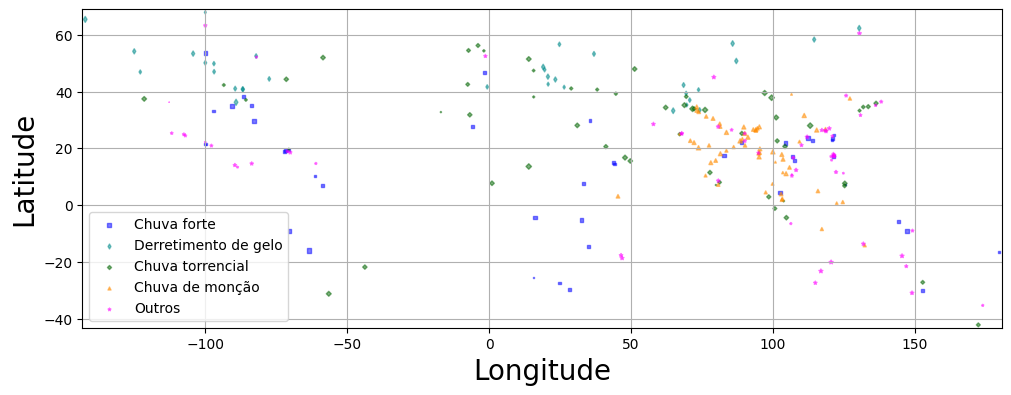

In [35]:
indClasse = [1,2,3,4,5]
cores = ['blue', 'darkcyan', 'darkgreen', 'darkorange', 'magenta']
simbolos = ['s', 'd', 'D', '^', '*']
nomes = ['Chuva forte', 'Derretimento de gelo', 'Chuva torrencial', 'Chuva de monção', 'Outros']

FS = (10,10)
fig = plt.figure(constrained_layout=True,figsize=FS)
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)

ax = fig.add_subplot(spec[0, 0])

for i,cor,simb,rotulo in zip(indClasse,cores,simbolos,nomes):
    pos = np.where(yD == i)[0]
    ax.scatter( xD[pos,0], xD[pos,1], s=xD[pos,5]*10, c=cor, marker=simb, alpha=0.5, label=rotulo) # type: ignore
    
ax.set_xlabel('Longitude',fontsize=20)
ax.set_ylabel('Latitude',fontsize=20)
ax.set(xlim=(np.min(xD[:,0])-1,np.max(xD[:,0])+1), ylim=(np.min(xD[:,1])-1,np.max(xD[:,1])+1))
ax.set_aspect('equal', 'box')
ax.legend()
ax.grid(True)

### Classificação dos dados
#### Diferentes quantidades de itens por folha (durante o treinamento)
* psi = {2, 10}
Outros parâmetros mantidos constantes - Observe!

In [36]:
#Instanciação dos classificadores
g1 = tree.DecisionTreeClassifier(criterion='entropy', min_samples_split=2, min_impurity_decrease=10**(-7),random_state=1)
g2 = tree.DecisionTreeClassifier(criterion='entropy', min_samples_split=10, min_impurity_decrease=10**(-7),random_state=1)

#0 - Severidade
#1 - Longitude
#2 - Latitute
#3 - Duração (dias)
#4- Área afetada (𝑘𝑚2)
#5 - Magnitude
atributos = [2,3,4,5]
xD_sub = xD[:,atributos]
xI_sub = xI[:,atributos]

#Treinamento dos classificadores 
g1.fit(xD_sub,yD)
g2.fit(xD_sub,yD)

DecisionTreeClassifier(criterion='entropy', min_impurity_decrease=1e-07,
                       min_samples_split=10, random_state=1)

### Avaliação do desempenho
* Análise baseada na concordância (%) entre Predição $vs$ Esperado.

In [37]:
#Predição efetuada por cada uma das redes
yEst_g1 = g1.predict(xI_sub)
yEst_g2 = g2.predict(xI_sub)

#Concordâncias...
concord_g1 = np.count_nonzero(yEst_g1 == yI) / yI.shape[0]
concord_g2 = np.count_nonzero(yEst_g2 == yI) / yI.shape[0]

print('Árvore 1: ', concord_g1)
print('Árvore 2: ', concord_g2)

Árvore 1:  0.25984251968503935
Árvore 2:  0.2440944881889764


### Qual classe acerta/erra mais?

In [38]:
for i in range(0,5):
    posClasse = np.where(yI == (i+1))
    acc = np.count_nonzero(yEst_g1[posClasse] == yI[posClasse]) / yI[posClasse].shape[0]
    print(nomes[i],': ',str(acc*100),'')

Chuva forte :  3.8461538461538463 
Derretimento de gelo :  33.33333333333333 
Chuva torrencial :  48.38709677419355 
Chuva de monção :  23.333333333333332 
Outros :  22.58064516129032 


In [39]:
path = 'Data/FloodData.csv'
y,x_ = read_class_data(path)
x = np.copy(x_)
AtributosNormalizar = [2,3,4,5]

for i in AtributosNormalizar:
    mi = x[:,i].min()
    ma = x[:,i].max()
    a = 1/(ma-mi)
    b = -mi/(ma-mi)
    x[:,i] = a*x[:,i] + b

N = y.shape[0]
percentAvalia = 0.33

#A ordenação dos valores aleatórios segundo seu índice/argumento
#O resultado é uma nova ordem aleatória (mais conveniente para este caso)
posAleatorias = np.argsort(np.random.uniform(0,1, y.shape[0] ))

#Subconjunto de avaliação
yI = y[ posAleatorias[0: np.int64(np.ceil(N*percentAvalia)) ] ]
xI = x[ posAleatorias[0: np.int64(np.ceil(N*percentAvalia)) ] , :]

#Subconjunto de treino
yD = y[ posAleatorias[np.int64(np.floor(N*percentAvalia)):-1] ]
xD = x[ posAleatorias[np.int64(np.floor(N*percentAvalia)):-1] , :]

In [40]:
np.int64(np.unique(yD))

array([1, 2, 3, 4, 5])

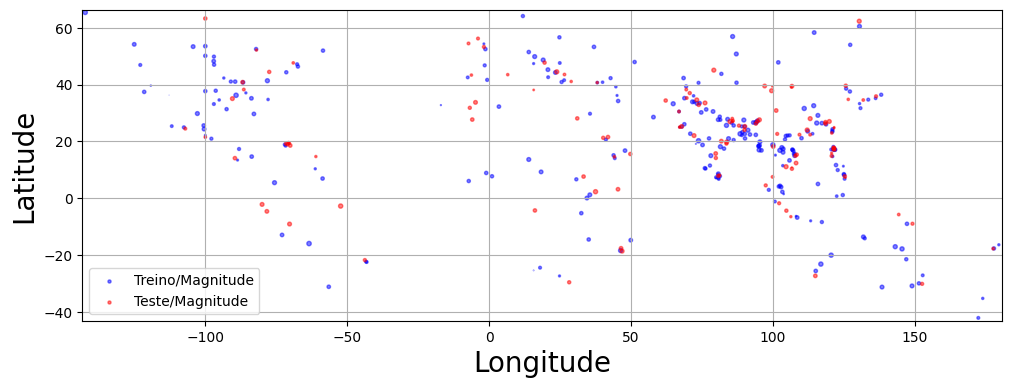

In [41]:
FS = (10,10)
fig = plt.figure(constrained_layout=True,figsize=FS)
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)

ax = fig.add_subplot(spec[0,0])
ax.scatter( xD[:,0], xD[:,1], s=xD[:,5]*10, c='blue', alpha=0.5, label='Treino/Magnitude')
ax.scatter( xI[:,0], xI[:,1], s=xI[:,5]*10, c='red', alpha=0.5, label='Teste/Magnitude')
ax.set_xlabel('Longitude',fontsize=20)
ax.set_ylabel('Latitude',fontsize=20)
ax.set(xlim=(np.min(xD[:,0])-1,np.max(xD[:,0])+1), ylim=(np.min(xD[:,1])-1,np.max(xD[:,1])+1))
ax.set_aspect('equal', 'box')
ax.legend(fontsize=10)
ax.grid(True)

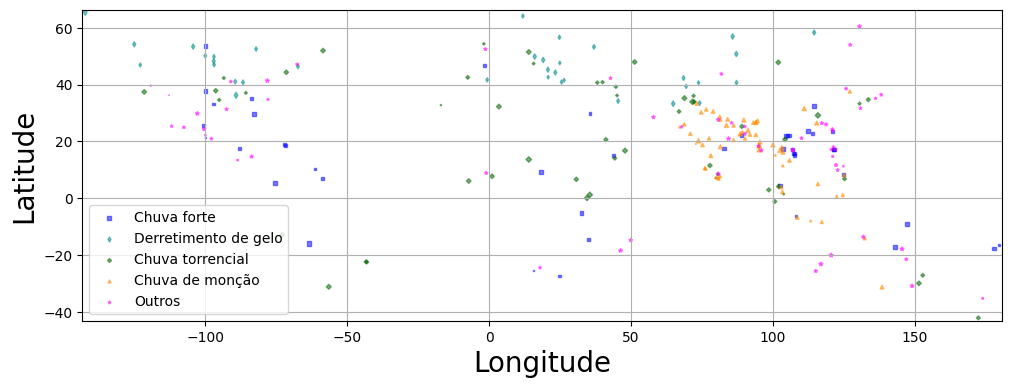

In [42]:
indClasse = [1,2,3,4,5]
cores = ['blue', 'darkcyan', 'darkgreen', 'darkorange', 'magenta']
simbolos = ['s', 'd', 'D', '^', '*']
nomes = ['Chuva forte', 'Derretimento de gelo', 'Chuva torrencial', 'Chuva de monção', 'Outros']

FS = (10,10)
fig = plt.figure(constrained_layout=True,figsize=FS)
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)

ax = fig.add_subplot(spec[0, 0])

for i,cor,simb,rotulo in zip(indClasse,cores,simbolos,nomes):
    pos = np.where(yD == i)[0]
    ax.scatter( xD[pos,0], xD[pos,1], s=xD[pos,5]*10, c=cor, marker=simb, alpha=0.5, label=rotulo) # type: ignore
    
ax.set_xlabel('Longitude',fontsize=20)
ax.set_ylabel('Latitude',fontsize=20)

ax.set(xlim=(np.min(xD[:,0])-1,np.max(xD[:,0])+1), ylim=(np.min(xD[:,1])-1,np.max(xD[:,1])+1))
ax.set_aspect('equal', 'box')

ax.legend()
ax.grid(True)

### Classificação dos dados
#### Diferentes arquiteturas (segundo hidden_layer_sizes):
* (6) -- 1 camada escondida com 6 neurônios $\rightarrow g_1$
* (3,3) -- 2 camadas escondidas com 3 neurônios cada $\rightarrow g_2$
* (2,2,2) -- 3 camadas escondidas com 2 neurônios cada $\rightarrow g_3$

Outros parâmetros mantidos constantes - Observe!

In [43]:
#Arquiteturas consideradas
arq1 = (3,2)
arq2 = (3,3)
arq3 = (2,2,2)

#Instanciação dos classificadores
g1 = MLPClassifier(hidden_layer_sizes=arq1, solver='lbfgs', max_iter=10000,
    activation='logistic', learning_rate='constant', shuffle=True, random_state=1)

g2 = MLPClassifier(hidden_layer_sizes=arq2, solver='lbfgs', max_iter=10000,
    activation='logistic', learning_rate='constant', shuffle=True, random_state=1)

g3 = MLPClassifier(hidden_layer_sizes=arq3, solver='lbfgs', max_iter=10000,
    activation='logistic', learning_rate='constant', shuffle=True, random_state=1)

#0 - Longitude
#1 - Latitute
#2 - Severidade
#3 - Duração (dias)
#4 - Área afetada (𝑘𝑚2)
#5 - Magnitude
atributos = [2,3,4,5]
xD_sub = xD[:,atributos]
xI_sub = xI[:,atributos]
 
g1.fit(xD_sub,yD)
g2.fit(xD_sub,yD)
g3.fit(xD_sub,yD)

MLPClassifier(activation='logistic', hidden_layer_sizes=(2, 2, 2),
              max_iter=10000, random_state=1, solver='lbfgs')

### Avaliação do desempenho
* Análise baseada na concordância (%) entre Predição $vs$ Esperado.

In [44]:
#Predição efetuada por cada uma das redes
yEst_g1 = g1.predict(xI_sub)
yEst_g2 = g2.predict(xI_sub)
yEst_g3 = g3.predict(xI_sub)

#Concordâncias...
concord_g1 = np.count_nonzero(yEst_g1 == yI) / yI.shape[0]
concord_g2 = np.count_nonzero(yEst_g2 == yI) / yI.shape[0]
concord_g3 = np.count_nonzero(yEst_g3 == yI) / yI.shape[0]

print('Rede 1: ', concord_g1)
print('Rede 2: ', concord_g2)
print('Rede 3: ', concord_g3)

Rede 1:  0.36220472440944884
Rede 2:  0.3228346456692913
Rede 3:  0.2047244094488189


### Qual classe acerta/erra mais? 

In [45]:
for i,rotulo in zip(indClasse,nomes):
    posClasse = np.where(yI == i)[0]
    acc = np.count_nonzero(yEst_g1[posClasse] == yI[posClasse]) / yI[posClasse].shape[0]
    print(rotulo,': ',str(acc*100),'')

Chuva forte :  0.0 
Derretimento de gelo :  0.0 
Chuva torrencial :  69.44444444444444 
Chuva de monção :  73.07692307692307 
Outros :  6.0606060606060606 


# Atividade:
* Faça uma representação espacial para os padrões classificados de forma correta (azul) e incorreta (vermelho)
* Teste outras arquiteturas de rede a fim de melhorar a acurácia da classificação 
* Para maiores detalhes sobre os parâmetros: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html